# Environment Setup

In [1]:
# Import needed modules

import os
import sys
import gc
import time
import torch
import numpy as np
from numba import cuda
from torch import optim
from torch import nn
from torch.nn import Conv2d
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import functional as F
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML, Javascript


In [2]:
# Set seed for PyTorch reproducibility

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# mount google drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/vision_project/'

# Add path to the list of directories (denseaspp)
sys.path.append(BASE_DIR + 'dataset')
sys.path.append(BASE_DIR + 'models/DenseASPP/models')
sys.path.append(BASE_DIR + 'models/DenseASPP/cfgs')
sys.path.append(BASE_DIR + 'models/DenseASPP/utils')
sys.path.append(BASE_DIR + 'utils')

# Add path to the list of directories (gscnn)
sys.path.append(BASE_DIR + 'dataset')
sys.path.append(BASE_DIR + 'models/GSCNN')
sys.path.append(BASE_DIR + 'utils')


Mounted at /content/drive


# Dataset

In [4]:
from woodscape import WoodScapesDataset
from woodscape_transforms import test_img_transform, test_annotation_transform, UnNormalize

dataset_dir = BASE_DIR + 'dataset/woodscape/data/'

generator = torch.Generator().manual_seed(42)
train_idxs, valid_idxs, test_idxs = random_split(range(2700), [0.8, 0.1, 0.1], generator=generator)
#n_examples = 1200

test_data = WoodScapesDataset(img_dir = dataset_dir + 'images',
                              annotation_dir= dataset_dir + 'semantic_annotations',
                              #idxs = [0,2]+list(np.random.randint(low=0, high=8100, size=n_examples)),
                              idxs = test_idxs,
                              transform=test_img_transform,
                              target_transform=test_annotation_transform,
                              )
test_iterator = DataLoader(test_data, batch_size=2)

# Networks

In [5]:
from DenseASPP161 import Model_CFG
from DenseASPP import DenseASPP
from network.gscnn import GSCNN

ckp_dir = BASE_DIR + "models/checkpoints/"

# Load DenseASPP (pre-trained on CityScapes)
denseaspp_cs = DenseASPP(Model_CFG, n_class=19, output_stride=8)
weights = torch.load(ckp_dir + "best_denseaspp_2.pt", map_location=torch.device('cpu'))
denseaspp_cs.load_state_dict(weights, strict=False)

# Load DenseASPP (fine-tuned on WoodScape)
denseaspp = DenseASPP(Model_CFG, n_class=9, output_stride=8)
weights = torch.load(ckp_dir + "denseaspp__f1_e5_p3_(lr=3e-4).pt", map_location=torch.device('cpu'))
denseaspp.load_state_dict(weights, strict=False)

# Load GSCNN (pre-trained on CityScapes)
gscnn_cs = GSCNN(num_classes=19)
weights = torch.load(ckp_dir + "best_gcnn_state_dict.pt", map_location=torch.device('cpu'))
gscnn_cs.load_state_dict(weights, strict=False)

# Load GSCNN (fine-tuned on WoodScape)
gscnn = GSCNN(num_classes=9)
weights = torch.load(ckp_dir + "gscnn_m6_e5p3.pt", map_location=torch.device('cpu'))
gscnn.load_state_dict(weights, strict=False);

/content/drive/MyDrive/vision_project/models/DenseASPP/models/DenseASPP.py:107: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)
/content/drive/MyDrive/vision_project/models/GSCNN/network/mynn.py:29: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


# Evaluation Metrics

In [6]:
def calculate_IoU(conf_matrix):
    # Extract true positives, false positives, and false negatives
    intersection = np.diag(conf_matrix)
    ground_truth_set = conf_matrix.sum(axis=1)
    predicted_set = conf_matrix.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    # Avoid division by zero
    IoU = intersection / np.maximum(union, 1)

    return IoU

def calculate_f1_score(confusion_matrix):
    # Initialize variables to accumulate precision and recall for each class
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_scores = np.zeros(num_classes)

    for i in range(num_classes):
        true_positive = confusion_matrix[i, i]
        false_positive = confusion_matrix[:, i].sum() - true_positive
        false_negative = confusion_matrix[i, :].sum() - true_positive

        if true_positive + false_positive == 0:
            precision[i] = 0
        else:
            precision[i] = true_positive / (true_positive + false_positive)

        if true_positive + false_negative == 0:
            recall[i] = 0
        else:
            recall[i] = true_positive / (true_positive + false_negative)

        if precision[i] + recall[i] == 0:
            f1_scores[i] = 0
        else:
            f1_scores[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    # Calculate the macro F1-score
    macro_f1_score = np.mean(f1_scores)
    return macro_f1_score

# Qualitative comparisons

In [7]:
# Predictions from DenseASPP (fine-tuned on WoodScape)

denseaspp.cuda()
denseaspp.eval()

with torch.no_grad():
  x, y = next(iter(test_iterator))
  x, y = x.cuda(), y.cuda()

  seg_out = denseaspp(x).detach().cpu()
  pred_1 = seg_out.max(1)[1]


In [8]:
# Predictions from GSCNN (fine-tuned on WoodScape)

gscnn.cuda()
gscnn.eval()

with torch.no_grad():
  seg_out, edge_out = gscnn(x)
  seg_out = seg_out.detach().cpu()
  pred_2 = seg_out.detach().max(1)[1].cpu()


In [9]:
# Predictions from DenseASPP (pre-trained on CityScapes)

denseaspp_cs.cuda()
denseaspp_cs.eval()

with torch.no_grad():
  seg_out = denseaspp_cs(x).detach().cpu()
  pred_3 = seg_out.max(1)[1]

In [10]:
# Predictions from GSCNN (pre-trained on CityScapes)

gscnn_cs.cuda()
gscnn_cs.eval()

with torch.no_grad():
  seg_out, edge_out = gscnn_cs(x)
  seg_out = seg_out.detach().cpu()
  pred_4 = seg_out.detach().max(1)[1].cpu()

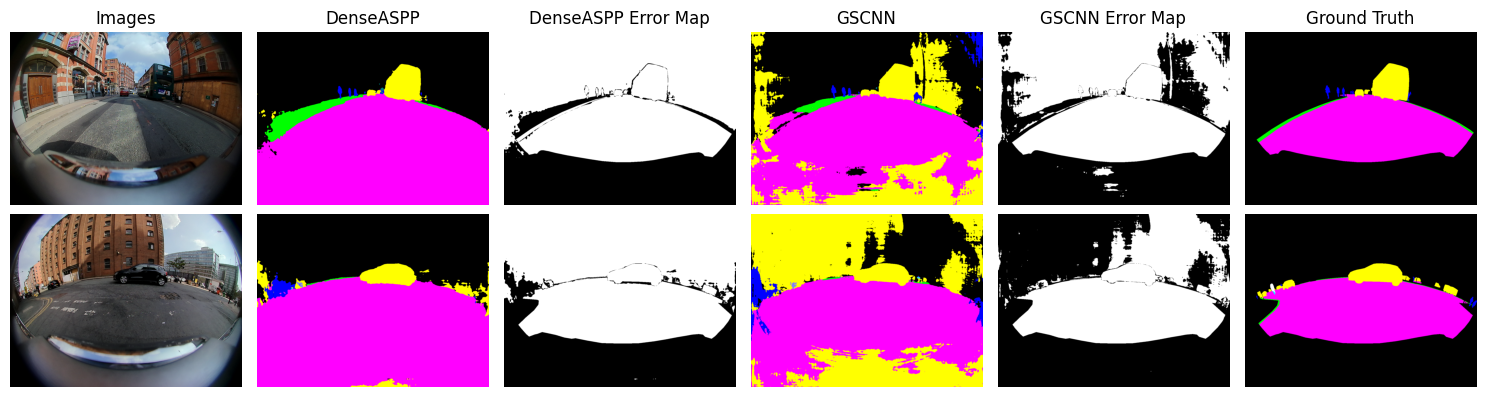

In [11]:
# Qualitative comparison of models pre-trained on CityScape

id_map = torch.tensor([1,2,0,0,0,0,0,8,0,0,0,3,4,5,5,5,5,7,6]) # map CityScapes ID to WoodScape ID
colormap = torch.tensor([[0, 0, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [255, 255, 0], [0, 255, 255], [128, 128, 255], [0, 128, 128]])

x = x.cpu()
y = y.long().cpu()
pred1 = id_map[pred_3.long().cpu()]
pred2 = id_map[pred_4.long().cpu()]

fig, axs = plt.subplots(len(x), 6, figsize=(15, 4))
for i, (img, gt, pred1, pred2) in enumerate(zip(x, y, pred1, pred2)):
    axs[i, 0].imshow(UnNormalize(img).permute(1, 2, 0))
    axs[i, 1].imshow(colormap[pred1])
    axs[i, 2].imshow(gt==pred1, cmap='gray')
    axs[i, 3].imshow(colormap[pred2])
    axs[i, 4].imshow(gt==pred2, cmap='gray')
    axs[i, 5].imshow(colormap[gt])
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
    axs[i, 3].axis('off')
    axs[i, 4].axis('off')
    axs[i, 5].axis('off')
    axs[0, 0].title.set_text('Images')
    axs[0, 1].title.set_text('DenseASPP')
    axs[0, 2].title.set_text('DenseASPP Error Map')
    axs[0, 3].title.set_text('GSCNN')
    axs[0, 4].title.set_text('GSCNN Error Map')
    axs[0, 5].title.set_text('Ground Truth')

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [12]:
fig.savefig('pretrained_models.png', format='png', dpi=300, bbox_inches='tight')

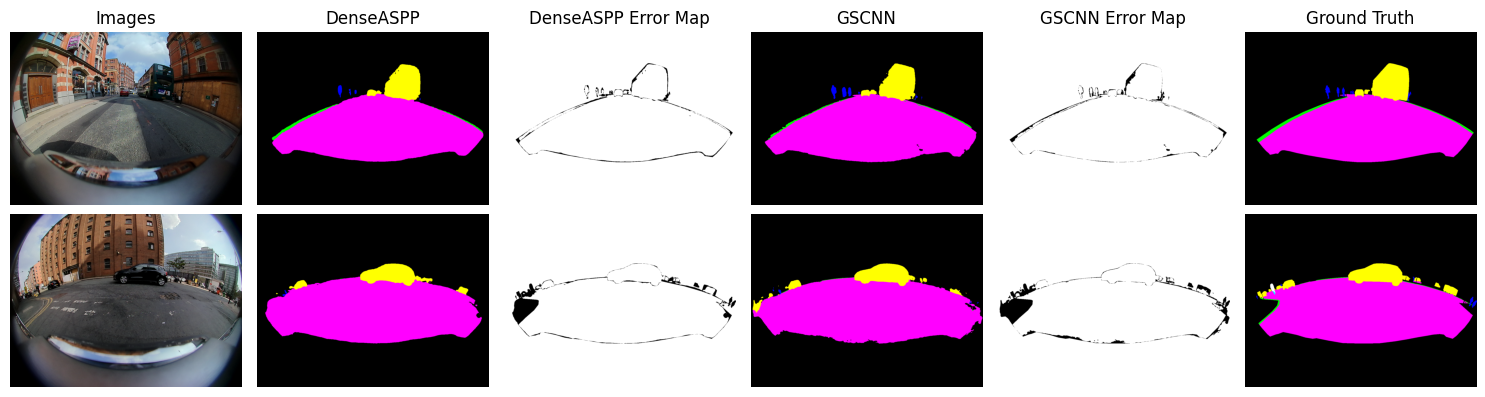

In [13]:
# Qualitative comparison of models fine-tuned on WoodScape

x = x.cpu()
y = y.long().cpu()
pred1 = pred_1.long().cpu()
pred2 = pred_2.long().cpu()

colormap = torch.tensor([[0, 0, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [255, 255, 0], [0, 255, 255], [128, 128, 255], [0, 128, 128]])

fig, axs = plt.subplots(len(x), 6, figsize=(15, 4))
for i, (img, gt, pred1, pred2) in enumerate(zip(x, y, pred1, pred2)):
    axs[i, 0].imshow(UnNormalize(img).permute(1, 2, 0))
    axs[i, 1].imshow(colormap[pred1])
    axs[i, 2].imshow(gt==pred1, cmap='gray')
    axs[i, 3].imshow(colormap[pred2])
    axs[i, 4].imshow(gt==pred2, cmap='gray')
    axs[i, 5].imshow(colormap[gt])
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
    axs[i, 3].axis('off')
    axs[i, 4].axis('off')
    axs[i, 5].axis('off')
    axs[0, 0].title.set_text('Images')
    axs[0, 1].title.set_text('DenseASPP')
    axs[0, 2].title.set_text('DenseASPP Error Map')
    axs[0, 3].title.set_text('GSCNN')
    axs[0, 4].title.set_text('GSCNN Error Map')
    axs[0, 5].title.set_text('Ground Truth')

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [14]:
fig.savefig('finetuned_models.png', format='png', dpi=300, bbox_inches='tight')

# Performance comparison on Woodscape test set

In [ ]:
denseaspp.cuda()
denseaspp.eval()

cm_1 = np.zeros((9,9), dtype=np.int64)

with torch.no_grad():
  for (x, y) in test_iterator:
    x = x.cuda()
    y = y.cuda()

    seg_out = denseaspp(x).detach().cpu()
    y_pred = seg_out.max(1)[1]

    y_true = y.cpu().view((-1,)).numpy()
    y_pred = y_pred.view((-1,)).numpy()

    cm_1 += confusion_matrix(y_true, y_pred, labels=range(9))

iou_1 = calculate_IoU(cm_1)
miou_1 = np.mean(iou_1)
f1_score_1 = calculate_f1_score(cm_1)

print(f"Test -- mIoU: {miou_1*100:.2f}%")
print(f"Test -- f1-score: {f1_score_1:.2f}")

Test -- mIoU: 38.54%
Test -- f1-score: 0.46


In [ ]:
gscnn.cuda()
gscnn.eval()

cm_2 = np.zeros((9,9), dtype=np.int64)

with torch.no_grad():
  for (x, y) in test_iterator:
    x = x.cuda()
    y = y.cuda()

    seg_out, edge_out = gscnn(x)
    seg_out = seg_out.detach().cpu()
    y_pred = seg_out.max(1)[1]

    y_true = y.cpu().view((-1,)).numpy()
    y_pred = y_pred.view((-1,)).numpy()

    cm_2 += confusion_matrix(y_true, y_pred, labels=range(9))

iou_2 = calculate_IoU(cm_2)
miou_2 = np.mean(iou_2)
f1_score_2 = calculate_f1_score(cm_2)

print(f"Test -- mIoU: {miou_2*100:.2f}%")
print(f"Test -- f1-score: {f1_score_2:.2f}")

Test -- mIoU: 50.28%
Test -- f1-score: 0.62


In [ ]:
classes = ("void", "road", "curb", "person", "rider", "vehicles", "bicycle", "motorcycle", "traffic_sign")
print("Class            DenseASPP        GatedSCNN")
print("-"*45)
for i in range(9):
  v1 = iou_1[i]
  v2 = iou_2[i]
  print(f"{classes[i].ljust(15)}    {v1*100:>6.2f}%           {v2*100:>6.2f}%")

Class            DenseASPP        GatedSCNN
---------------------------------------------
void                95.16%            94.07%
road                91.88%            89.10%
curb                43.35%            44.65%
person              29.90%            40.11%
rider                0.00%            40.73%
vehicles            69.67%            71.11%
bicycle              8.73%            36.14%
motorcycle           1.55%            32.55%
traffic_sign         6.59%             4.10%
